In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from dataset.travel_time_dataset import TravelTimeDataset
from model.early_stopping import EarlyStopping

from scipy.signal import butter, filtfilt

In [21]:
cfg = {
    'data': {
        'path': 'E:/data/real_data/304.csv',
        'feature': 'delta_t',
        'window_size': 21,
        'split_type': 'a',
        'train_split_size': 0.6,
        'val_split_size': 0.2
    },
    'plots': {
        'show_plots': True,
        'color_actual': '#001F3F',
        'color_train': '#3D9970',
        'color_val': '#0074D9',
        'color_test': '#FF4136',
        'color_pred_train': '#3D9970',
        'color_pred_val': '#0074D9',
        'color_pred_test': '#FF4136',
    },
    'optimizer': {
        'name': 'adam',
        'lr': 0.001,
        'beta': (0.9, 0.999),
        'eps': 1e-8,
        'momentum': 0.9,
        'weight_decay': 1e-6,
    },
    'scheduler': {
        'step_size': 10,
    },
    'train': {
        'device': 'cuda',
        'batch_size': 32,
        'num_epoch': 200,
        'checkpoint_path': 'E:/checkpoints/model_weight',
    }
}

# Split data

In [22]:
def plot_actual(series):
    plt.figure(figsize=(25, 5), dpi=80)
    idx = np.arange(0, len(series))
    plt.plot(idx, series, color='#001f3f')

    plt.grid(b=None, which='major', axis='y', linestyle='--')

In [23]:
def split_data_over(cfg):
    times = [i for i in range(21)]

    num_data_points_list = []
    df_list = []

    df = pd.read_csv(cfg['data']['path'], index_col=0, parse_dates=True)

    if cfg['data']['split_type'] == 't':
        period = 3
        time_part = 21 // period
        time_list = [times[i * period:i * period + period] for i in range(time_part)]
        for idx, time in enumerate(time_list):
            df_tmp = df[df.index.hour.isin(time)]
            
            num_data_points_list.append(len(df_tmp))
            df_list.append(df_tmp)  
    elif cfg['data']['split_type'] == 'd':
        day_list = [[0, 1], [2, 3, 4], [5, 6]]
        for idx, day in enumerate(day_list):
            df_tmp = df[df.index.day_of_week.isin(day)]

            num_data_points_list.append(len(df_tmp))
            df_list.append(df_tmp)
    elif cfg['data']['split_type'] == 'a':
        period = 21
        time_part = 21 // period
        time_list = [times[i * period:i * period + period] for i in range(time_part)]
        for idx, time in enumerate(time_list):
            df_tmp = df[df.index.hour.isin(time)]
            
            num_data_points_list.append(len(df_tmp['2020-01-01' :'2020-04-30']))
            df_list.append(df_tmp['2020-01-01' :'2020-04-30'])
            
    return df_list, num_data_points_list

In [24]:
dfs, num_data_points_list = split_data_over(cfg)

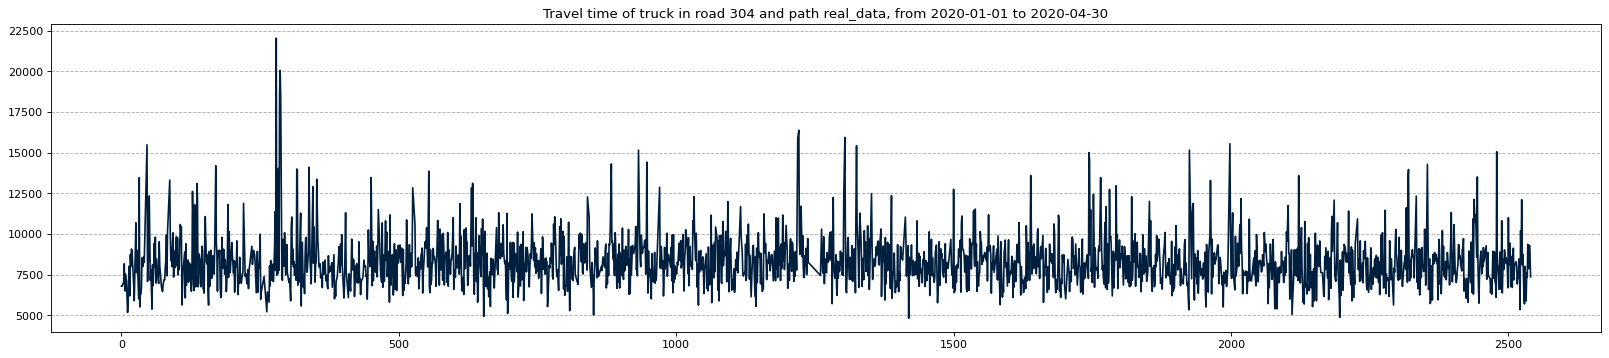

In [25]:
plot_actual(dfs[0]['delta_t'])

road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
path = cfg['data']['path'].split('/')[-2]
plt.title(f"Travel time of truck in road {road} and path {path}, from 2020-01-01 to 2020-04-30")

plt.show()

# Data preparation: Denoise

In [26]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [27]:
for idx, df in enumerate(dfs):
    denoise = butter_lowpass_filter(df['delta_t'].to_list(), cutoff=3, fs=10, order=2)
    dfs[idx]['denoise'] = denoise

In [28]:
dfs[0]

,delta_t,day_of_week,denoise
datetime,,,
2020-01-01 00:00:00,6782.0,2.0,6781.880907
2020-01-01 01:00:00,6782.0,2.0,6824.567549
2020-01-01 02:00:00,6868.0,2.0,6808.637881
2020-01-01 03:00:00,6954.0,2.0,6912.783439
2020-01-01 04:00:00,7040.0,2.0,7374.502047
...,...,...,...
2020-04-30 16:00:00,8126.2,3.0,8315.217662
2020-04-30 17:00:00,7860.0,3.0,8186.547374
2020-04-30 18:00:00,9301.0,3.0,8904.691545


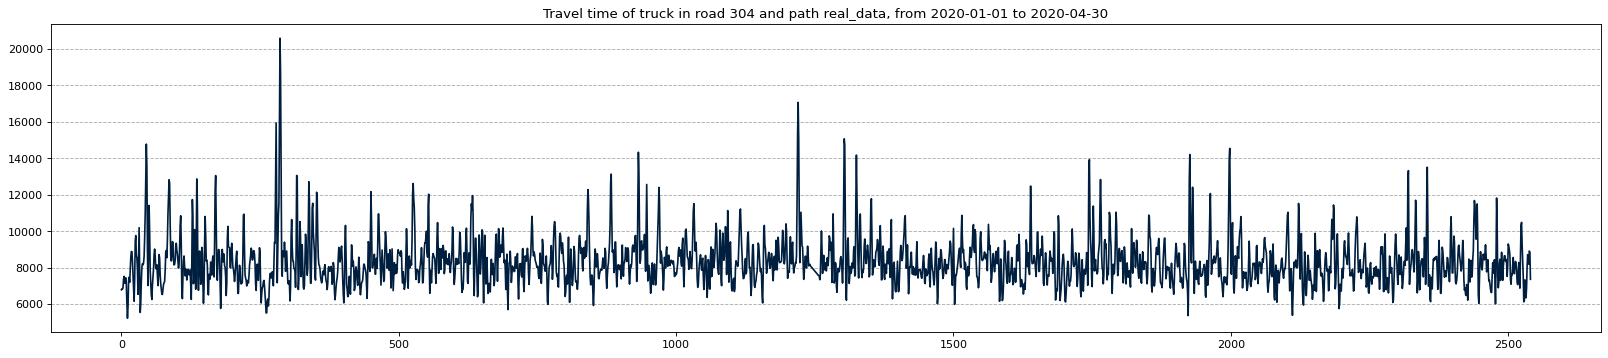

In [29]:
plot_actual(dfs[0]['denoise'])

road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
path = cfg['data']['path'].split('/')[-2]
plt.title(f"Travel time of truck in road {road} and path {path}, from 2020-01-01 to 2020-04-30")

plt.show()

# Data preparation: normalize raw data

In [30]:
class Normalizer:
    def __init__(self):
        self.data = None
        self.std_diff = 0
        self.mean_diff = 0

    def fit_transform(self, data):
        self.data = data

        # first difference
        diff_data = data.diff().fillna(data)

        # normalize
        self.mean_diff, self.std_diff = diff_data.mean(), diff_data.std()
        normalize_data = (diff_data - self.mean_diff) / self.std_diff

        return normalize_data

    def inverse_transform(self, data, split_data_index=0):
        inverse_data = []
        for idx in range(len(data)):
            # check first data
            if (idx + split_data_index) == 0:
                _data = (data[idx] * self.std_diff) + self.mean_diff + self.data[0]
            else:
                _data = (data[idx] * self.std_diff) + self.mean_diff + self.data[(idx - 1) + split_data_index]
            inverse_data.append(_data)

        inverse_series = pd.Series(inverse_data, index=data.index)

        return inverse_series

In [31]:
scaler_list = [Normalizer() for _ in range(len(dfs))]
normalize_data_list = [scaler_list[idx].fit_transform(dfs[idx]['denoise']) for idx in range(len(dfs))]

# Data preparation: generating training, test and validation data

In [32]:
def preprocess(data, window_size):
    X, y, y_date = [], [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i].to_list())
        y.append(data[i])
        y_date.append(data.index[i])
    return np.array(X), np.array(y), np.array(y_date)

def generate_train_test_val(normalize_data, num_data_points, scaler, cfg, plot=False):
    # split data for test model
    # split data
    data_test = normalize_data[:]

    # split data y
    data_x_test, data_y_test, data_date_y_test = preprocess(data_test, cfg['data']['window_size'])

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_data_y_test = np.zeros(num_data_points)
        
        data_y_test_series = pd.Series(data_y_test, index=data_date_y_test)

        to_plot_data_y_test[cfg['data']['window_size']:] = scaler.inverse_transform(data_y_test_series, cfg['data']['window_size'])

        to_plot_data_y_test = np.where(to_plot_data_y_test == 0, None, to_plot_data_y_test)

        idx = np.arange(0, len(normalize_data))

        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, to_plot_data_y_test, label='travel time (test)', color=cfg['plots']['color_test'])

        plt.title(f"Travel time of truck in rode {road} ({path}) - show traning, test and validation data")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return data_x_test, data_y_test, data_date_y_test

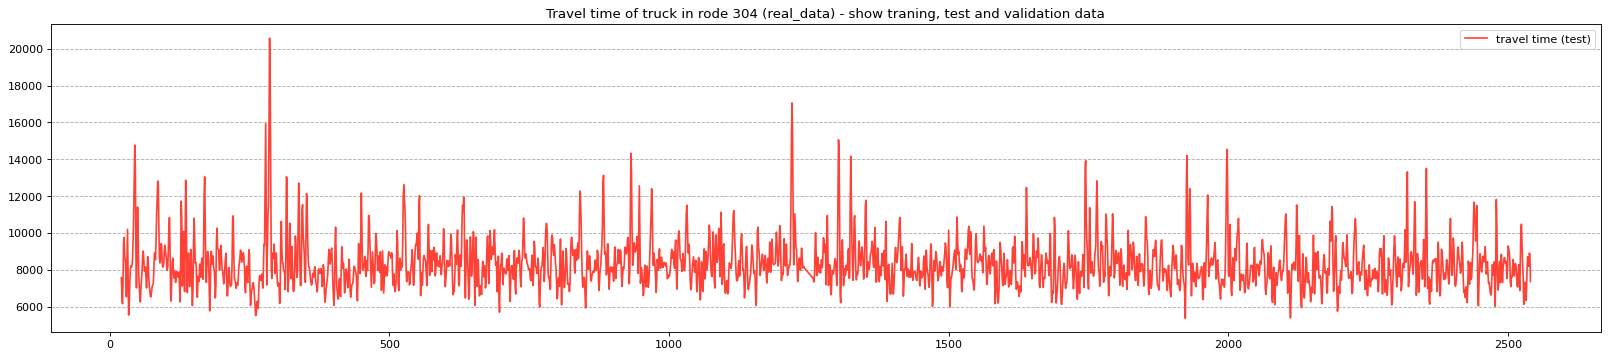

In [33]:
data_x_test_list, data_y_test_list, data_date_y_test_list = [], [], []
for idx in range(len(normalize_data_list)):
    data_x_test, data_y_test, data_date_y_test = generate_train_test_val(normalize_data_list[idx], num_data_points_list[idx], scaler_list[idx], cfg, True)
    data_x_test_list.append(data_x_test)
    data_y_test_list.append(data_y_test)
    data_date_y_test_list.append(data_date_y_test)

In [34]:
dataset_test = []
for idx in range(len(data_x_test_list)):
    dataset_test.append(TravelTimeDataset(data_x_test_list[idx], data_y_test_list[idx]))
    print(f"time : {idx}")
    print(f"Test data for model shape: {dataset_test[idx].x.shape} {dataset_test[idx].y.shape}")

time : 0
Test data for model shape: (2520, 21, 1) (2520,)


# Define model

In [35]:
class AttentionalLSTM(nn.Module):
    def __init__(self, input_size, qkv, hidden_size, num_layers, output_size, bidirectional=False):
        super(AttentionalLSTM, self).__init__()

        self.input_size = input_size
        self.qkv = qkv
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.query = nn.Linear(input_size, qkv)
        self.key = nn.Linear(input_size, qkv)
        self.value = nn.Linear(input_size, qkv)

        self.attn = nn.Linear(qkv, input_size)
        self.scale = math.sqrt(qkv)

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        self.dropout = nn.Dropout(0.5)
        
        if bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # print(x.shape)
        Q, K, V = self.query(x), self.key(x), self.value(x)

        dot_product = torch.matmul(Q, K.permute(0, 2, 1)) / self.scale
        scores = torch.softmax(dot_product, dim=-1)
        scaled_x = torch.matmul(scores, V) + x

        out = self.attn(scaled_x) + x

        # print(f"out : {out.shape}")

        out, _ = self.lstm(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        # print(out.shape)
        out = self.fc(out)

        return out

In [36]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

# Model evaluation

In [37]:
def eval(dataset_test, data_date_y_test, scaler, model, cfg, best_model_name, df, plot=False):
    print(best_model_name)
    # init tool for train model
    # craete dataloader
    test_dataloader = DataLoader(dataset_test, batch_size=cfg['train']['batch_size'], shuffle=False)

    checkpoint = torch.load(os.path.join(cfg['train']['checkpoint_path'], best_model_name + '.pth'))
    model.load_state_dict(checkpoint['net'])

    predicted_test = np.array([])

    model.eval()
    for batch_idx, (x, y) in enumerate(test_dataloader):
        x = x.to(cfg['train']['device'])
        pred = model(x.float())
        pred = pred.cpu().detach().numpy()
        predicted_test = np.concatenate((predicted_test, pred[:, 0]))

    predict_test_series = pd.Series(predicted_test, index=data_date_y_test)

    mse = mean_squared_error(df['delta_t'][cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, cfg['data']['window_size']))
    rmse = math.sqrt(mean_squared_error(df['delta_t'][cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, cfg['data']['window_size'])))
    mae = mean_absolute_error(df['delta_t'][cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, cfg['data']['window_size']))
    r2 = r2_score(df['delta_t'][cfg['data']['window_size']:].to_list(), scaler.inverse_transform(predict_test_series, cfg['data']['window_size']))

    if plot:
        road = (cfg['data']['path'].split('/')[-1]).split('.')[0]
        path = cfg['data']['path'].split('/')[-2]

        to_plot_predicted_test = scaler.inverse_transform(predict_test_series, cfg['data']['window_size'])

        idx = np.arange(0, len(predict_test_series[:]))

        #plot
        fig = plt.figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(idx, df['delta_t'][cfg['data']['window_size']:], label='Actual travel time', color=cfg['plots']['color_actual'])
        plt.plot(idx, to_plot_predicted_test[:], label='Predicted travel time (test)', color=cfg['plots']['color_pred_test'])
        plt.title(f"Examine predicted travel time on test data portion of road with real data {road} ({path}) [MSE: {mse:.3f} | RMSE: {rmse:.3f} | MAE: {mae:.3f}]")
        plt.grid(b=None, which='major', axis='y', linestyle='--')
        plt.legend()
        plt.show()

    return mse, rmse, mae, r2

# Build and test model

butterworth_road_304


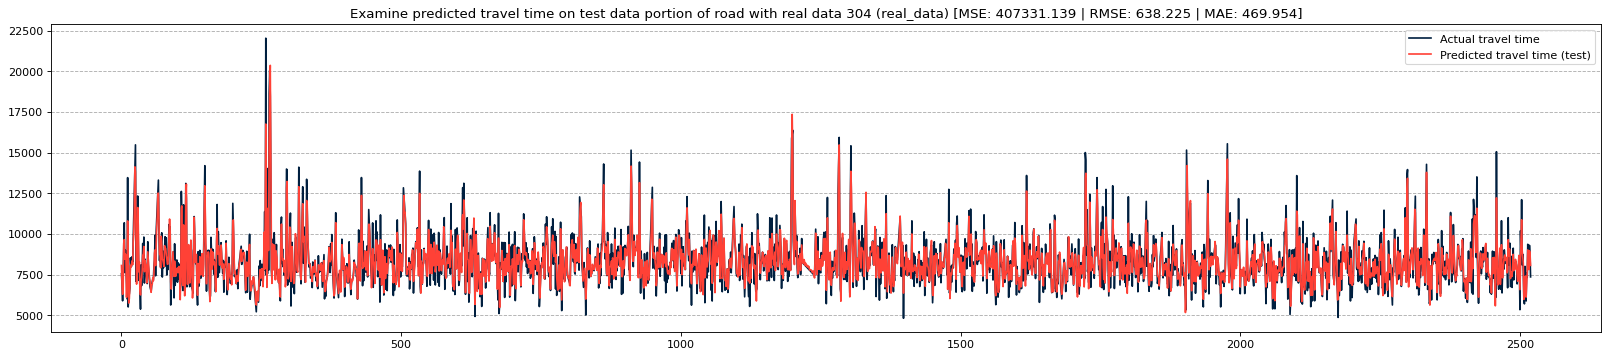

time : 0
MSE : 407331.1387388749 || RMSE : 638.2249906881389 || MAE : 469.95372709389574


In [38]:
result = []
for idx in range(len(dataset_test)):
    model = AttentionalLSTM(input_size=1, qkv=cfg['data']['window_size'], hidden_size=256, num_layers=1, output_size=1, bidirectional=False)
    model.apply(init_weights)
    if torch.cuda.is_available():
        cfg['train']['device'] = 'cuda'
    else:
        cfg['train']['device'] = 'cpu'
    model = model.to(cfg['train']['device'])

    road = os.path.basename(cfg['data']['path']).split('.')[0]
    mse, rmse, mae, r2 = eval(dataset_test[idx], data_date_y_test_list[idx], scaler_list[idx], model, cfg, f"butterworth_road_{road}", dfs[idx], True)

    print(f"time : {idx}")
    print(f"MSE : {mse} || RMSE : {rmse} || MAE : {mae}")
    print(f"==================================================================================")

    result.append({
        'name': f"time-{idx}",
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
    })

report = pd.DataFrame(result)

In [39]:
print(f"rmse : {report['rmse'].mean()}")
print(f"mae : {report['mae'].mean()}")

rmse : 638.2249906881389
mae : 469.95372709389574
